In [1]:
import numpy as np
import igraph
from scipy import sparse
from scipy.sparse import csc_matrix
import matplotlib.pyplot as plt
from bluepy import Circuit
import matplotlib.patches as mpatches
from scipy.sparse import csc_matrix
import tqdm
import os

In [2]:
dpi=300
file_format = 'png'
fig_save_dir = f'{os.getcwd()}/output/'

In [3]:
adj_path = '/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/data/ca1_ca3_to_slice10_synaptome.npz'

In [4]:
adj = sparse.load_npz(adj_path)
adj = adj[:adj.shape[1],:]

In [4]:
connectome = adj.copy()
connectome[connectome>1]=1

In [5]:
connectome.max()

1.0

In [6]:
adj.shape

(12615, 12615)

In [7]:
np.max(adj)

99.0

In [8]:
max_degree = np.max(adj.sum(axis=0))

In [9]:
indegrees = adj.sum(axis=1).A.flatten()
outdegrees = adj.sum(axis=0).A.flatten()

In [10]:
indegrees.max()

27213.0

In [11]:
connectome.sum(axis=1).A.flatten().max()

3732.0

In [12]:
adj.sum() / (adj.shape[0] * (adj.shape[1]-1))

0.09652777450468218

In [13]:
adj.count_nonzero()

2779593

------
## Rich Club

In [5]:
class RichClubAnalysis:
    """
    Class for performing rich club analysis on a square sparse CSC matrix.
    """
    
    def __init__(self, adjacency_matrix):
        """
        Initialize the RichClubAnalysis object.
        
        Parameters:
            adjacency_matrix (scipy.sparse.csc_matrix): Square sparse CSC matrix representing the graph adjacency.
        """
        self.adjacency_matrix = adjacency_matrix
        self.is_MultiGraph = np.any(adj.A > 1)
        self.is_Directed = not np.array_equal(adjacency_matrix, adjacency_matrix.T)

    def undirected_rich_club_coefficient(self, k):
        """
        Calculate the rich club coefficient for a given degree threshold.
        
        Parameters:
            k (int): Degree threshold.
            
        Returns:
            float: Rich club coefficient.
        """
        if self.is_Directed:
            raise ValueError("Error: The graph is directed!") 

        degrees = np.array(self.adjacency_matrix.sum(axis=0)).flatten()
        k_degrees = degrees[degrees >= k]
        kc = self.adjacency_matrix[degrees >= k, :][:, degrees >= k]
        kc_indices = kc.nonzero()
        kc_count = len(kc_indices[0])
        kc_possible = len(k_degrees) * (len(k_degrees) - 1)
        if kc_possible == 0:
            return np.nan
        return (2 * kc_count) / kc_possible
    
    def directed_rich_club_coefficient(self, k):
        """
        Calculate the rich club coefficient for a given degree threshold.
        
        Parameters:
            k (int): Degree threshold.
            
        Returns:
            float: Rich club coefficient.
        """
        if not self.is_Directed:
            raise ValueError("Error: The graph is undirected! Use undirected_rich_club_coefficient") 
            
        degrees = np.array(self.adjacency_matrix.sum(axis=0)).flatten() + np.array(self.adjacency_matrix.sum(axis=1)).flatten() # out + indegrees per node
        k_degrees = degrees[degrees >= k]
        kc = self.adjacency_matrix[degrees >= k, :][:, degrees >= k]
        kc_indices = kc.nonzero()
        kc_count = len(kc_indices[0])
        kc_possible = len(k_degrees) * (len(k_degrees) - 1)
        if kc_possible == 0:
            return np.nan
        return (kc_count) / kc_possible
    
    def plot_rich_club(self):
        """
        Plot the rich club coefficient for different degree thresholds.
        """
        degrees = np.array(self.adjacency_matrix.sum(axis=0)).flatten()
        k_values = np.unique(degrees)
        rc_coefficients = [self.rich_club_coefficient(k) for k in k_values]
        
        plt.plot(k_values, rc_coefficients, 'o-')
        plt.xlabel('Degree Threshold (k)')
        plt.ylabel('Rich Club Coefficient')
        plt.title('Rich Club Analysis')
        plt.show()


In [6]:
rca = RichClubAnalysis(adj)

<__array_function__ internals>:200: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.


In [16]:
rca.is_Directed

True

In [17]:
rca.is_MultiGraph

True

In [18]:
k=1000
degrees = np.array(rca.adjacency_matrix.sum(axis=0)).flatten() + np.array(rca.adjacency_matrix.sum(axis=1)).flatten() # out + indegrees per node
k_degrees = degrees[degrees >= k]
kc = rca.adjacency_matrix[degrees >= k, :][:, degrees >= k]
kc_indices = kc.nonzero()
kc_count = len(kc_indices[0])
kc_possible = len(k_degrees) * (len(k_degrees) - 1)

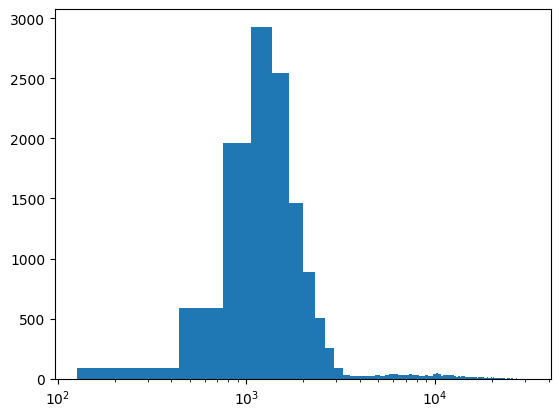

In [19]:
plt.hist(degrees,bins=100)
plt.xscale('log')

In [7]:
import networkx as nx
import igraph

# Create a networkx graph from the adjacency matrix
graph = igraph.Graph.Adjacency(adj.A)

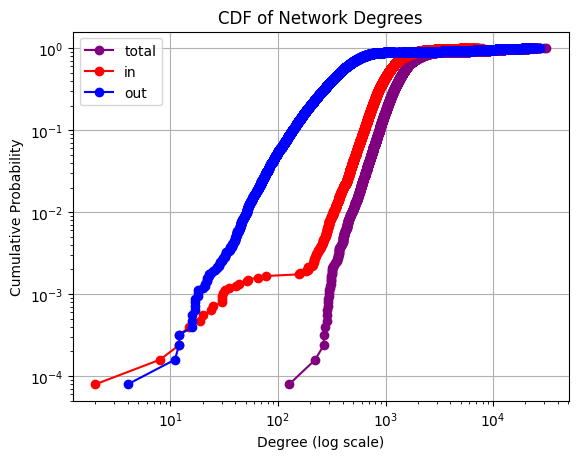

In [24]:
# Get the degrees of the nodes
degrees = graph.degree()
indegrees = graph.indegree()
outdegrees = graph.outdegree()

# Sort the degrees in ascending order
sorted_degrees = np.sort(degrees)
sorted_indegrees = np.sort(indegrees)
sorted_outdegrees = np.sort(outdegrees)

# Calculate the empirical CDF
cumulative_prob = np.arange(1, len(sorted_degrees) + 1) / len(sorted_degrees)
cumulative_prob2 = np.arange(1, len(sorted_indegrees) + 1) / len(sorted_indegrees)
cumulative_prob3 = np.arange(1, len(sorted_outdegrees) + 1) / len(sorted_outdegrees)

# Plot the CDF
plt.plot(sorted_degrees, cumulative_prob, marker='o', linestyle='-', color='purple')
plt.plot(sorted_indegrees, cumulative_prob2, marker='o', linestyle='-', color='red')
plt.plot(sorted_outdegrees, cumulative_prob3, marker='o', linestyle='-', color='blue')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Degree (log scale)')
plt.ylabel('Cumulative Probability')
plt.title('CDF of Network Degrees')
plt.grid(True)
plt.legend(['total','in','out'])
plt.show()



In [25]:
k_degrees.shape

(10485,)

In [7]:
from tqdm import tqdm

In [39]:
indegrees = adj.sum(axis=0).flatten()
outdegrees = adj.sum(axis=1).flatten()
total_degrees = indegrees + outdegrees

In [40]:
indegrees

matrix([[  41.,   15.,   35., ..., 1059., 3345., 3537.]])

In [42]:
# Create an instance of RichClubAnalysis
rca = RichClubAnalysis(adj)

# Calculate rich club coefficient for degree threshold of 2

k_dict = {}
for k in tqdm(np.arange(1,np.max(indegrees))):
    rc_coefficient = rca.directed_rich_club_coefficient(k)
    k_dict[k] = rc_coefficient
# print(f"Rich Club Coefficient for k=2: {rc_coefficient}")

# Plot the rich club analysis
# rca.plot_rich_club()

<__array_function__ internals>:200: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
100%|██████████| 7973/7973 [09:49<00:00, 13.52it/s]


In [54]:
len(graph.vs.degree())

12615

In [57]:
communities = graph.as_undirected().community_fastgreedy()

In [63]:
communities.summary()

'Dendrogram, 12615 elements, 12614 merges'

Text(0, 0.5, 'Coefficient')

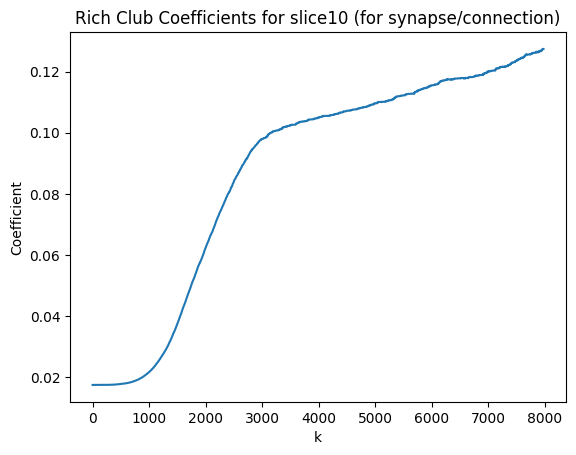

In [43]:
plt.plot(k_dict.keys(),k_dict.values())
plt.title('Rich Club Coefficients for slice10 (for synapse/connection)')
plt.xlabel('k')
plt.ylabel('Coefficient')

In [8]:
import networkx as nx
import dask
import dask.bag as db
from dask.distributed import Client
from itertools import accumulate

def calculate_rc_coefficient(G, deghist, total, nks, edge_degrees, d):
    ek = G.number_of_edges()
    k1, k2 = edge_degrees.pop()
    rc = {}
    for d, nk in enumerate(nks):
        while k1 <= d:
            if len(edge_degrees) == 0:
                ek = 0
                break
            k1, k2 = edge_degrees.pop()
            ek -= 1
        rc[d] = 2 * ek / (nk * (nk - 1))
    return d, rc[d]

def _compute_rc_parallel(G, degree_dict):
    deghist = nx.degree_histogram(G)
    total = sum(deghist)
    nks = (total - cs for cs in accumulate(deghist) if total - cs > 1)
    edge_degrees = sorted((sorted(map(G.degree, e)) for e in G.edges()), reverse=True)
    degree_values = [degree_dict[node] for node in G.nodes()]
    unique_degrees = sorted(set(degree_values))
    
    rc_dict = {}

    # Create a Dask bag from the unique_degrees
    degree_bag = db.from_sequence(unique_degrees)

    # Parallelize the calculation of rc_coefficient for each degree
    results = degree_bag.map(calculate_rc_coefficient, G, deghist, total, nks, edge_degrees).compute()

    # Collect the results into rc_dict
    for d, rc_coefficient in results:
        rc_dict[d] = rc_coefficient

    return rc_dict

def rich_club_coefficient_parallel(G, normalized=True, Q=100, seed=None):
    degree_dict = dict(nx.degree(G))
    rc_dict = _compute_rc_parallel(G, degree_dict)
    
    if normalized:
        R = G.copy()
        E = R.number_of_edges()
        nx.double_edge_swap(R, Q * E, max_tries=Q * E * 10, seed=seed)
        rcran = _compute_rc_parallel(R, degree_dict)
        rc_dict = {k: v / rcran[k] for k, v in rc_dict.items()}
    
    return rc_dict


In [9]:
import networkx as nx

In [10]:
G = nx.from_scipy_sparse_array(adj)

In [11]:
from bluepysnap import Circuit
CIRCUIT_DIR = '/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/'
c = Circuit(f'{CIRCUIT_DIR}/sonata/circuit_config.json')
nodes = c.nodes['hippocampus_neurons']

In [12]:
target_mtypes = nodes.get('slice10').mtype.values

In [13]:
target_mtype_dict = {i:value for i,value in enumerate(target_mtypes)}

In [14]:
nx.set_node_attributes(G, target_mtype_dict, "mtype")

In [15]:
G_undirected = G.to_undirected()

In [16]:
# rc = nx.rich_club_coefficient(G_undirected, normalized=False, seed=42)

In [19]:
client = Client()

/gpfs/bbp.cscs.ch/home/kurban/venv2022/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44020 instead
  warnings.warn(
2023-07-06 23:26:03,754 - distributed.diskutils - INFO - Found stale lock file and directory '/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/kurban/1609211/dask-worker-space/worker-n2wh4in2', purging
2023-07-06 23:26:03,756 - distributed.diskutils - INFO - Found stale lock file and directory '/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/kurban/1609211/dask-worker-space/worker-dywsz8jb', purging
2023-07-06 23:26:03,757 - distributed.diskutils - INFO - Found stale lock file and directory '/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/kurban/1609211/dask-worker-space/worker-qd5ok1ht', purging
2023-07-06 23:26:03,761 - distributed.diskutils - INFO - Found stale lock file and directory '/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/kurban/1609211/dask-worker-space/worker-gmhgikcd', purging
2023-07-06 23:2

In [ ]:
# Start Dask client

rc_parallel_undir = rich_club_coefficient_parallel(G_undirected, normalized=False, Q=100, seed=None)

# Shutdown the Dask client
client.shutdown()


In [ ]:
rc_parallel_undir

In [146]:
# Create an instance of RichClubAnalysis
rca = RichClubAnalysis(connectome)

# Calculate rich club coefficient for degree threshold of 2
connectome_tot_degree = connectome.sum(axis=0) + connectome.sum(axis=1)

k_dict_conn = {}
for k in tqdm.tqdm(np.arange(1,int(np.max(connectome_tot_degree))+1)):
    rc_coefficient = rca.rich_club_coefficient(k)
    k_dict_conn[k] = rc_coefficient

100%|██████████| 5225/5225 [01:14<00:00, 69.96it/s] 


Text(0, 0.5, 'Coefficient')

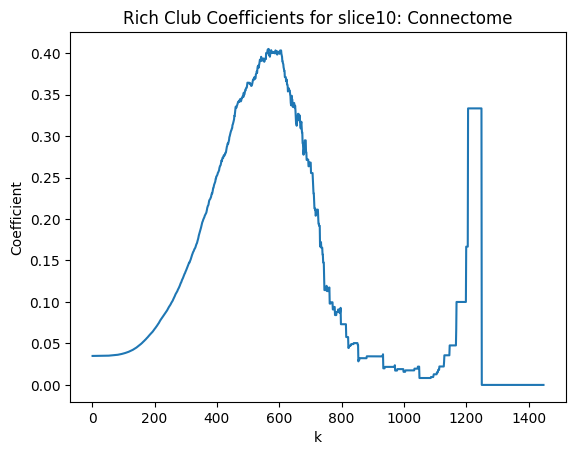

In [147]:
plt.plot(k_dict_conn.keys(),k_dict_conn.values())
plt.title('Rich Club Coefficients for slice10: Connectome')
plt.xlabel('k')
plt.ylabel('Coefficient')

For multiple slices

In [ ]:
targets = [i for i in c.cells.targets if i.startswith('slice') and not i.endswith('400um') ]

for i in targets:
    # Create an instance of RichClubAnalysis
    rca = RichClubAnalysis(adj)

    # Calculate rich club coefficient for degree threshold of 2

    k_dict = {}
    for k in np.arange(1,int(np.max(adj))):
        rc_coefficient = rca.rich_club_coefficient(k)
        k_dict[k] = rc_coefficient
    # print(f"Rich Club Coefficient for k=2: {rc_coefficient}")

    # Plot the rich club analysis
    # rca.plot_rich_club()

## Hubs

Text(0.5, 1.0, 'Slice10')

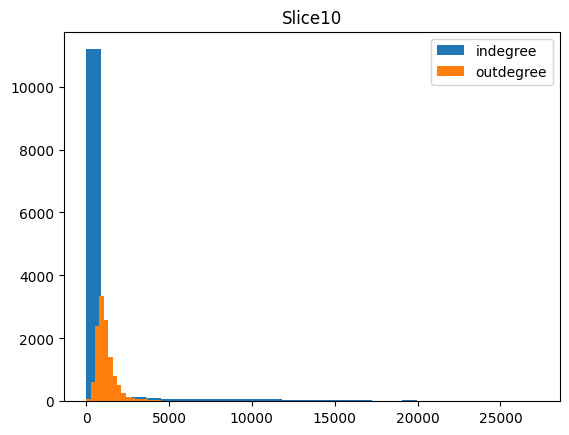

In [81]:
_=plt.hist(indegrees,bins=30)
_=plt.hist(outdegrees,bins=30)
plt.legend(['indegree','outdegree'])
plt.title('Slice10')

In [119]:
target = 'All-All'
inhub_threshold = np.round(np.mean(indegrees) + np.std(indegrees))
outhub_threshold = np.round(np.mean(outdegrees) + np.std(outdegrees))
print(f'{target} inhub threshold (mean + 1 std): {inhub_threshold}\nOuthub threshold (mean + 1 std): {outhub_threshold}')

num_inhubs = len(np.where(indegrees>inhub_threshold)[0])
num_outhubs = len(np.where(outdegrees>outhub_threshold)[0])

inhub_percentage = np.round(100*num_inhubs/indegrees.shape[0],2)
outhub_percentage = np.round(100*num_outhubs/outdegrees.shape[0],2)

print(f'There are {num_inhubs} ({inhub_percentage}%) inhubs and {num_outhubs} ({outhub_percentage}%) outhubs.')

All-All inhub threshold (mean + 1 std): 4215.0
Outhub threshold (mean + 1 std): 1925.0
There are 969 (7.68%) inhubs and 1274 (10.1%) outhubs.


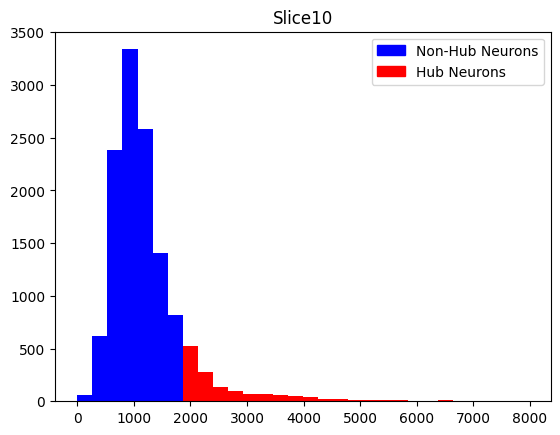

In [121]:
target = 'All-All'
n, bins, patches = plt.hist(outdegrees,bins=30,color='blue')
plt.title('Slice10')

threshold = outhub_threshold
plt.legend([f'outdegree {target}'])

red_patch = mpatches.Patch(color='red', label='Bins > Threshold')
plt.legend(handles=[red_patch])


# Iterate over the patches and set color for bins higher than the threshold
red_patches = []
non_red_patches = []
for i in range(len(patches)):
    if bins[i + 1] > threshold:
        patches[i].set_facecolor('red')
        red_patches.append(patches[i])
    else:
        non_red_patches.append(patches[i])

# Create legend patches
red_patch = mpatches.Patch(color='red', label='Hub Neurons')
non_red_patch = mpatches.Patch(color='blue', label='Non-Hub Neurons')

# Add the legend to the plot
plt.legend(handles=[non_red_patch,red_patch])
        
# plt.xscale('log')

## EXC Subnetwork Hubs

In [48]:
from bluepy import Circuit
from pathlib import Path

CIRCUIT_DIR = Path('/gpfs/bbp.cscs.ch/project/proj112/circuits/CA1/20211110-BioM/')
c = Circuit((CIRCUIT_DIR / 'CircuitConfig').as_posix())

In [49]:
#PCPC degrees
target_idx = np.intersect1d(c.cells.ids('SP_PC'),c.cells.ids('slice10'))-1

In [66]:
target_idx.shape

(11214,)

In [71]:
target_indices_in_adj = np.where(np.isin(c.cells.ids('slice10')-1,target_idx))[0]

In [74]:
target_exc_to_all = adj[target_indices_in_adj,:]
target_exc_to_exc = target_exc_to_all[:,target_indices_in_adj]

Text(0.5, 1.0, 'Slice10')

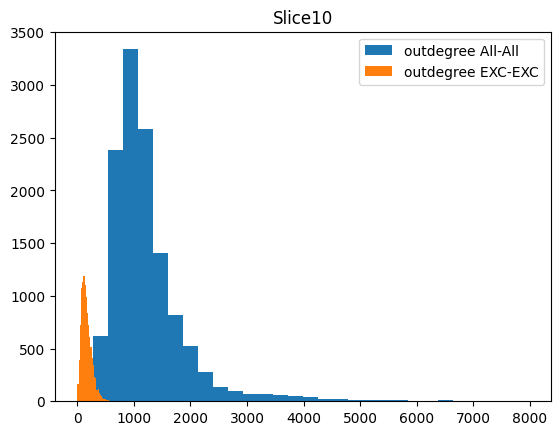

In [87]:
outdegrees = adj.sum(axis=0).A.flatten()
outdegrees_EXC = target_exc_to_exc.sum(axis=0).A.flatten()
_=plt.hist(outdegrees,bins=30)
_=plt.hist(outdegrees_EXC,bins=30)
plt.legend(['outdegree All-All','outdegree EXC-EXC'])
plt.title('Slice10')
# plt.xscale('log')

Text(0.5, 1.0, 'Slice10')

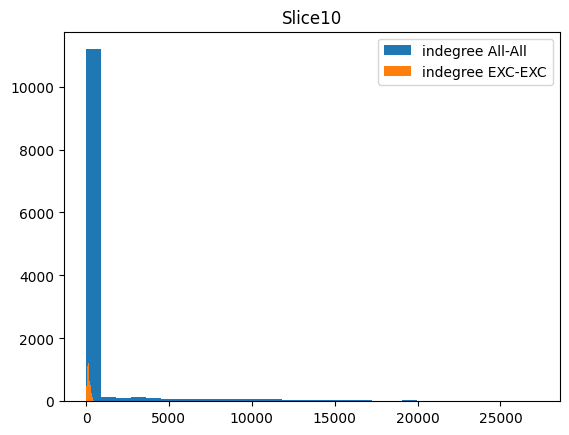

In [86]:
indegrees = adj.sum(axis=1).A.flatten()
indegrees_EXC = target_exc_to_exc.sum(axis=1).A.flatten()
_=plt.hist(indegrees,bins=30)
_=plt.hist(indegrees_EXC,bins=30)
plt.legend(['indegree All-All','indegree EXC-EXC'])
plt.title('Slice10')
# plt.xscale('log')

Text(0.5, 1.0, 'Slice10')

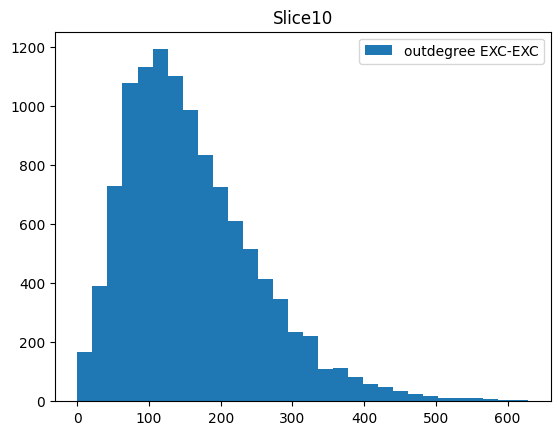

In [89]:
_=plt.hist(outdegrees_EXC,bins=30)
plt.legend(['outdegree EXC-EXC'])
plt.title('Slice10')
# plt.xscale('log')

In [104]:
indegrees_EXC.shape[0]

11214

In [107]:
inhub_threshold_EXC = np.round(np.mean(indegrees_EXC) + np.std(indegrees_EXC))
outhub_threshold_EXC = np.round(np.mean(outdegrees_EXC) + np.std(outdegrees_EXC))
print(f'EXC inhub threshold (mean + 1 std): {inhub_threshold_EXC}\nEXC outhub threshold (mean + 1 std): {outhub_threshold_EXC}')

num_EXC_inhubs = len(np.where(indegrees_EXC>inhub_threshold_EXC)[0])
num_EXC_outhubs = len(np.where(outdegrees_EXC>outhub_threshold_EXC)[0])

inhub_percentage_EXC = np.round(100*num_EXC_inhubs/indegrees_EXC.shape[0],2)
outhub_percentage_EXC = np.round(100*num_EXC_outhubs/outdegrees_EXC.shape[0],2)

print(f'There are {num_EXC_inhubs} ({inhub_percentage_EXC}%) EXC inhubs and {num_EXC_outhubs} ({outhub_percentage_EXC}%) EXC outhubs.')

EXC inhub threshold (mean + 1 std): 258.0
EXC outhub threshold (mean + 1 std): 253.0
There are 1874 (16.71%) EXC inhubs and 1715 (15.29%) EXC outhubs.


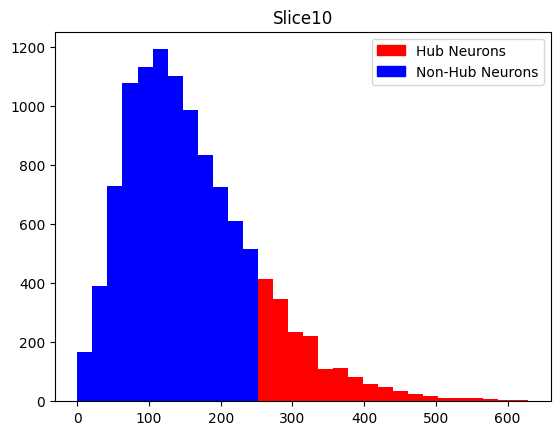

In [116]:
n, bins, patches = plt.hist(outdegrees_EXC,bins=30,color='blue')
plt.title('Slice10')

threshold = outhub_threshold_EXC

        
plt.legend(['outdegree EXC-EXC'])

import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Bins > Threshold')
plt.legend(handles=[red_patch])


# Iterate over the patches and set color for bins higher than the threshold
red_patches = []
non_red_patches = []
for i in range(len(patches)):
    if bins[i + 1] > threshold:
        patches[i].set_facecolor('red')
        red_patches.append(patches[i])
    else:
        non_red_patches.append(patches[i])

# Create legend patches
red_patch = mpatches.Patch(color='red', label='Hub Neurons')
non_red_patch = mpatches.Patch(color='blue', label='Non-Hub Neurons')

# Add the legend to the plot
plt.legend(handles=[red_patch, non_red_patch])
        
# plt.xscale('log')

In [97]:
indegrees_EXC

array([183., 271.,  96., ...,  24., 103.,  89.])

In [99]:
len(np.where(indegrees_EXC>inhub_threshold_EXC)[0])

1874

In [93]:
inhub_threshold = np.round(np.mean(indegrees) + np.std(indegrees))
outhub_threshold = np.round(np.mean(outdegrees) + np.std(outdegrees))
print(f'inhub threshold (mean + 1 std): {inhub_threshold}\nouthub threshold (mean + 1 std): {outhub_threshold}')

inhub threshold (mean + 1 std): 4215.0
outhub threshold (mean + 1 std): 1925.0


In [71]:
inhub_indices = np.where(indegrees>inhub_threshold)[0]
print(f'There are {len(inhub_indices)} high indegree nodes with at least one std away from mean.')

There are 969 high indegree nodes with at least one std away from mean.


In [72]:
outhub_indices = np.where(outdegrees>outhub_threshold)[0]
print(f'There are {len(outhub_indices)} high outdegree nodes with at least one std away from mean.')

There are 1274 high outdegree nodes with at least one std away from mean.


In [ ]:
# see if provincial or connector hub
## needs the modular component to check the connectors from i.e. slices, cubes etc